**Vamos experimentar agora a Rede Neural Artificial?**
Veja:
https://scikit-learn.org/stable/modules/neural_networks_supervised.html# 

In [154]:
!pip -q install yellowbrick
!pip -q install imbalanced-learn

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from imblearn.over_sampling import SMOTE
from scipy import stats
from collections import Counter

**Ler a base CSV**

In [156]:
data = pd.read_csv('breast-cancer.csv')


**Convertendo os dados nominais para dados numéricos**

In [157]:
categorical_cols = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'breast', 'breast-quad', 'irradiat']

encoder = OneHotEncoder(sparse=False, drop='first')
encoded_data = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(input_features=categorical_cols))

data = pd.concat([data.drop(columns=categorical_cols), encoded_df], axis=1)
data['Class'] = data['Class'].map({'no-recurrence-events': 0, 'recurrence-events': 1})


c:\Users\eduol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**Eliminar redundâncias nos dados através de colunas altamente correlacionadas**

In [158]:
correlation_matrix = data.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape, dtype=bool), k=1))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]  # Ajuste o limite de correlação conforme necessário
data = data.drop(columns=to_drop)

print(correlation_matrix)

                       deg-malig     Class  age_30-39  age_40-49  age_50-59  \
deg-malig               1.000000  0.299400   0.046313   0.016290   0.023117   
Class                   0.299400  1.000000   0.099192   0.004147   0.057214   
age_30-39               0.046313  0.099192   1.000000   0.257143   0.269737   
age_40-49               0.016290  0.004147   0.257143   1.000000   0.481673   
age_50-59               0.023117  0.057214   0.269737   0.481673   1.000000   
age_60-69               0.045018  0.001138   0.189322   0.338075   0.354632   
age_70-79               0.109045  0.041811   0.055549   0.099195   0.104053   
menopause_lt40          0.071934  0.003982   0.008110   0.107335   0.079082   
menopause_premeno       0.031758  0.052386   0.340224   0.509545   0.257235   
tumor-size_10-14        0.213471  0.188487   0.054072   0.020552   0.009931   
tumor-size_15-19        0.069193  0.047840   0.042098   0.109112   0.001690   
tumor-size_20-24        0.006901  0.022960   0.00815

In [159]:
X = data.drop('Class', axis=1)
y = data['Class']


**Balanceando os dados**

In [160]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f'Antes do oversampling: {Counter(y)}')
print(f'Depois do oversampling: {Counter(y_resampled)}')

Antes do oversampling: Counter({0: 201, 1: 85})
Depois do oversampling: Counter({0: 201, 1: 100})


In [161]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

**Identificar outliers e normalizar os dados**

In [162]:
Q1 = X_treino.quantile(0.25)
Q3 = X_treino.quantile(0.75)
IQR = Q3 - Q1

outliers = (X_treino < (Q1 - 1.5 * IQR)) | (X_treino > (Q3 + 1.5 * IQR))
X_treino[outliers] = np.nan
X_treino = X_treino.fillna(X_treino.median())


**Padronizar os dados**

In [163]:
scaler = StandardScaler()
X_treino = scaler.fit_transform(X_treino)
X_teste = scaler.transform(X_teste)

**Vamos treinar com a rede neural?**

In [164]:
modelo = MLPClassifier(max_iter=1000, verbose=True)
modelo.fit(X_treino, y_treino)

previsoes = modelo.predict(X_teste)
accuracy_score(y_teste,previsoes)

Iteration 1, loss = 0.71988165
Iteration 2, loss = 0.70561053
Iteration 3, loss = 0.69332636
Iteration 4, loss = 0.68170992
Iteration 5, loss = 0.67104871
Iteration 6, loss = 0.66144274
Iteration 7, loss = 0.65332424
Iteration 8, loss = 0.64454909
Iteration 9, loss = 0.63830923
Iteration 10, loss = 0.63206004
Iteration 11, loss = 0.62625977
Iteration 12, loss = 0.62118351
Iteration 13, loss = 0.61688767
Iteration 14, loss = 0.61300321
Iteration 15, loss = 0.60993206
Iteration 16, loss = 0.60657964
Iteration 17, loss = 0.60386075
Iteration 18, loss = 0.60152261
Iteration 19, loss = 0.59953254
Iteration 20, loss = 0.59755403
Iteration 21, loss = 0.59568707
Iteration 22, loss = 0.59420809
Iteration 23, loss = 0.59257148
Iteration 24, loss = 0.59141508
Iteration 25, loss = 0.59006389
Iteration 26, loss = 0.58904190
Iteration 27, loss = 0.58784994
Iteration 28, loss = 0.58672886
Iteration 29, loss = 0.58580601
Iteration 30, loss = 0.58474333
Iteration 31, loss = 0.58379568
Iteration 32, los

0.7704918032786885

**Ajuste dos hiperparâmetros automaticamente**

In [165]:
param_grid = {
    'max_iter': [500, 1000, 1500],  # Número máximo de iterações
    'verbose': [True, False],  # Exibir informações de depuração
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerância para parar o treinamento
    'solver': ['lbfgs', 'sgd', 'adam'],  # Otimizador
    'activation': ['logistic', 'tanh', 'relu'],  # Função de ativação
    'hidden_layer_sizes': [(5,), (10,), (5, 5), (10, 10), (10, 5, 2)],  # Topologias da rede
}

modelo = MLPClassifier()
scoring = make_scorer(accuracy_score)

grid_search = GridSearchCV(modelo, param_grid, cv=5, scoring=scoring, n_jobs=-1)
grid_search.fit(X_treino, y_treino)

print("Melhores Hiperparâmetros:")
print(grid_search.best_params_)

Melhores Hiperparâmetros:
{'activation': 'logistic', 'hidden_layer_sizes': (10,), 'max_iter': 1000, 'solver': 'lbfgs', 'tol': 0.01, 'verbose': False}


**Modelo com os melhores parâmetros identificados pelo GSCV**

In [166]:
melhor_modelo = grid_search.best_estimator_
previsoes = melhor_modelo.predict(X_teste)
acuracia = accuracy_score(y_teste, previsoes)

print(f'Acurácia do Melhor Modelo: {acuracia}')


Acurácia do Melhor Modelo: 0.7704918032786885




> **Vamos testar o modelo?**



In [168]:
previsoes = melhor_modelo.predict(X_teste)

In [169]:
previsoes

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0], dtype=int64)



> **Será se o modelo acertou?**



In [170]:
y_teste

177    1
289    1
228    0
198    0
60     1
      ..
234    0
296    1
281    0
285    0
182    0
Name: Class, Length: 61, dtype: int64

In [171]:
accuracy_score(y_teste,previsoes)

0.7704918032786885

In [172]:
confusion_matrix(y_teste, previsoes)

array([[36,  4],
       [10, 11]], dtype=int64)

c:\Users\eduol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7868852459016393

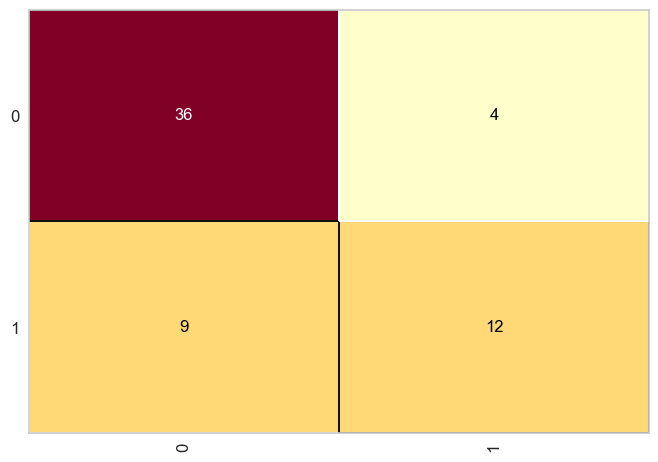

In [173]:
cm = ConfusionMatrix(modelo)
cm.fit(X_treino, y_treino)
cm.score(X_teste, y_teste)

In [174]:
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84        40
           1       0.73      0.52      0.61        21

    accuracy                           0.77        61
   macro avg       0.76      0.71      0.72        61
weighted avg       0.77      0.77      0.76        61



**Veja como implementar o backpropagation em python:**
https://www.askpython.com/python/examples/backpropagation-in-python
https://www.deeplearningbook.com.br/algoritmo-backpropagation-em-python/
